# Computer Vision Face Expression Detection Using Convolutional Neural Networks and Deep Learning with Pytorch
---

- Fine-Tuning pre-trained models
- Training and validating during the train loop
- Detailed evaluation report

### Research Material

https://rocm.docs.amd.com/en/latest/conceptual/ai-pytorch-inception.html#deep-learning-training

---

## Mounting Google Drive
---

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Debug
print(IN_COLAB)
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import the required libraries
---

In [ ]:
# !pip install --upgrade jcopdl==1.1.10

In [ ]:
import os
import random
import time
import platform
from tqdm import tqdm
# from jcopdl.callback import Callback, set_config

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils

## Setting for reporducibility
---

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Checking GPU Access
---

In [ ]:
# Check if the GPU is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [ ]:
!nvidia-smi

Wed Aug 20 13:20:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## The dataset
---

In [ ]:
if IN_COLAB:
  ds_path = '/content/drive/My Drive/Data/faces-emotion-recognition/faces/'
else:
  ds_path = '/home/'

## Seting up the experiment folder
---

In [ ]:
EXP_PATH = '/content/drive/My Drive/exp-fer_p3_01/'
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

## Setting some hyperparameters
---

In [ ]:
# Batch size (mini-batch size)
batch_size = 64
# Learning rate
lr = 0.001
# Mommentum
mm = 0.9
# Number of training epochs
epochs = 50 # Use a small value during development, 2 for example.
# Step size - For the learning rate scheduler (StepLR).
ss = 10

In [ ]:
# Select the network architecture.
ARCH_NAME = 'resnet18' # 'simplenet', 'alexnet', 'resnet18', ...
# Note: 'simplenet' refers to the architecture we developed.
# For information on additional architectures, please refer to the torchvision documentation: https://pytorch.org/vision/stable/models.html.

## Preparing the dataset
---

In [ ]:
# Data transforms
train_transform = transforms.Compose([
    # It is necessary to resize the image to match the network's input size.
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # Mean and standard deviation of ImageNet
    # These are required as we will use a model pre-trained on ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # It is necessary to resize the image to match the network's input size.
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # Mean and standard deviation of ImageNet
    # These are required as we will use a model pre-trained on ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = datasets.ImageFolder(ds_path+'train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

val_set = datasets.ImageFolder(ds_path+'validation', transform=test_transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = datasets.ImageFolder(ds_path+'test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
num_classes = len(train_set.classes)

# Print some basic information about the train and test datasets
print('Classes: {}'.format(train_set.classes))
print('Number of classes: {}'.format(num_classes))

print('Number of training examples: {}'.format(len(train_set)))
print('Number of validation examples: {}'.format(len(val_set)))
print('Number of test examples: {}'.format(len(test_set)))
print('Batch size: {}'.format(batch_size))

# Print some basic information about the train and test loaders
print('Number of training batches: {}'.format(len(train_loader)))
print('Number of validation batches: {}'.format(len(val_loader)))
print('Number of test batches: {}'.format(len(test_loader)))

# Check the shape of the training images
images, labels = next(iter(train_loader))
print("Shape of training images:", images.shape)
print("Shape of training labels:", labels.shape)

# Check the range of the pixel values in the training images
print("Minimum pixel value:", torch.min(images))
print("Maximum pixel value:", torch.max(images))

Classes: ['angry', 'fear', 'happy', 'neutral', 'sad']
Number of classes: 5
Number of training examples: 24945
Number of validation examples: 2350
Number of test examples: 3170
Batch size: 64
Number of training batches: 390
Number of validation batches: 37
Number of test batches: 50
Shape of training images: torch.Size([64, 3, 224, 224])
Shape of training labels: torch.Size([64])
Minimum pixel value: tensor(-2.1179)
Maximum pixel value: tensor(2.6400)


## Visualizing some images
---

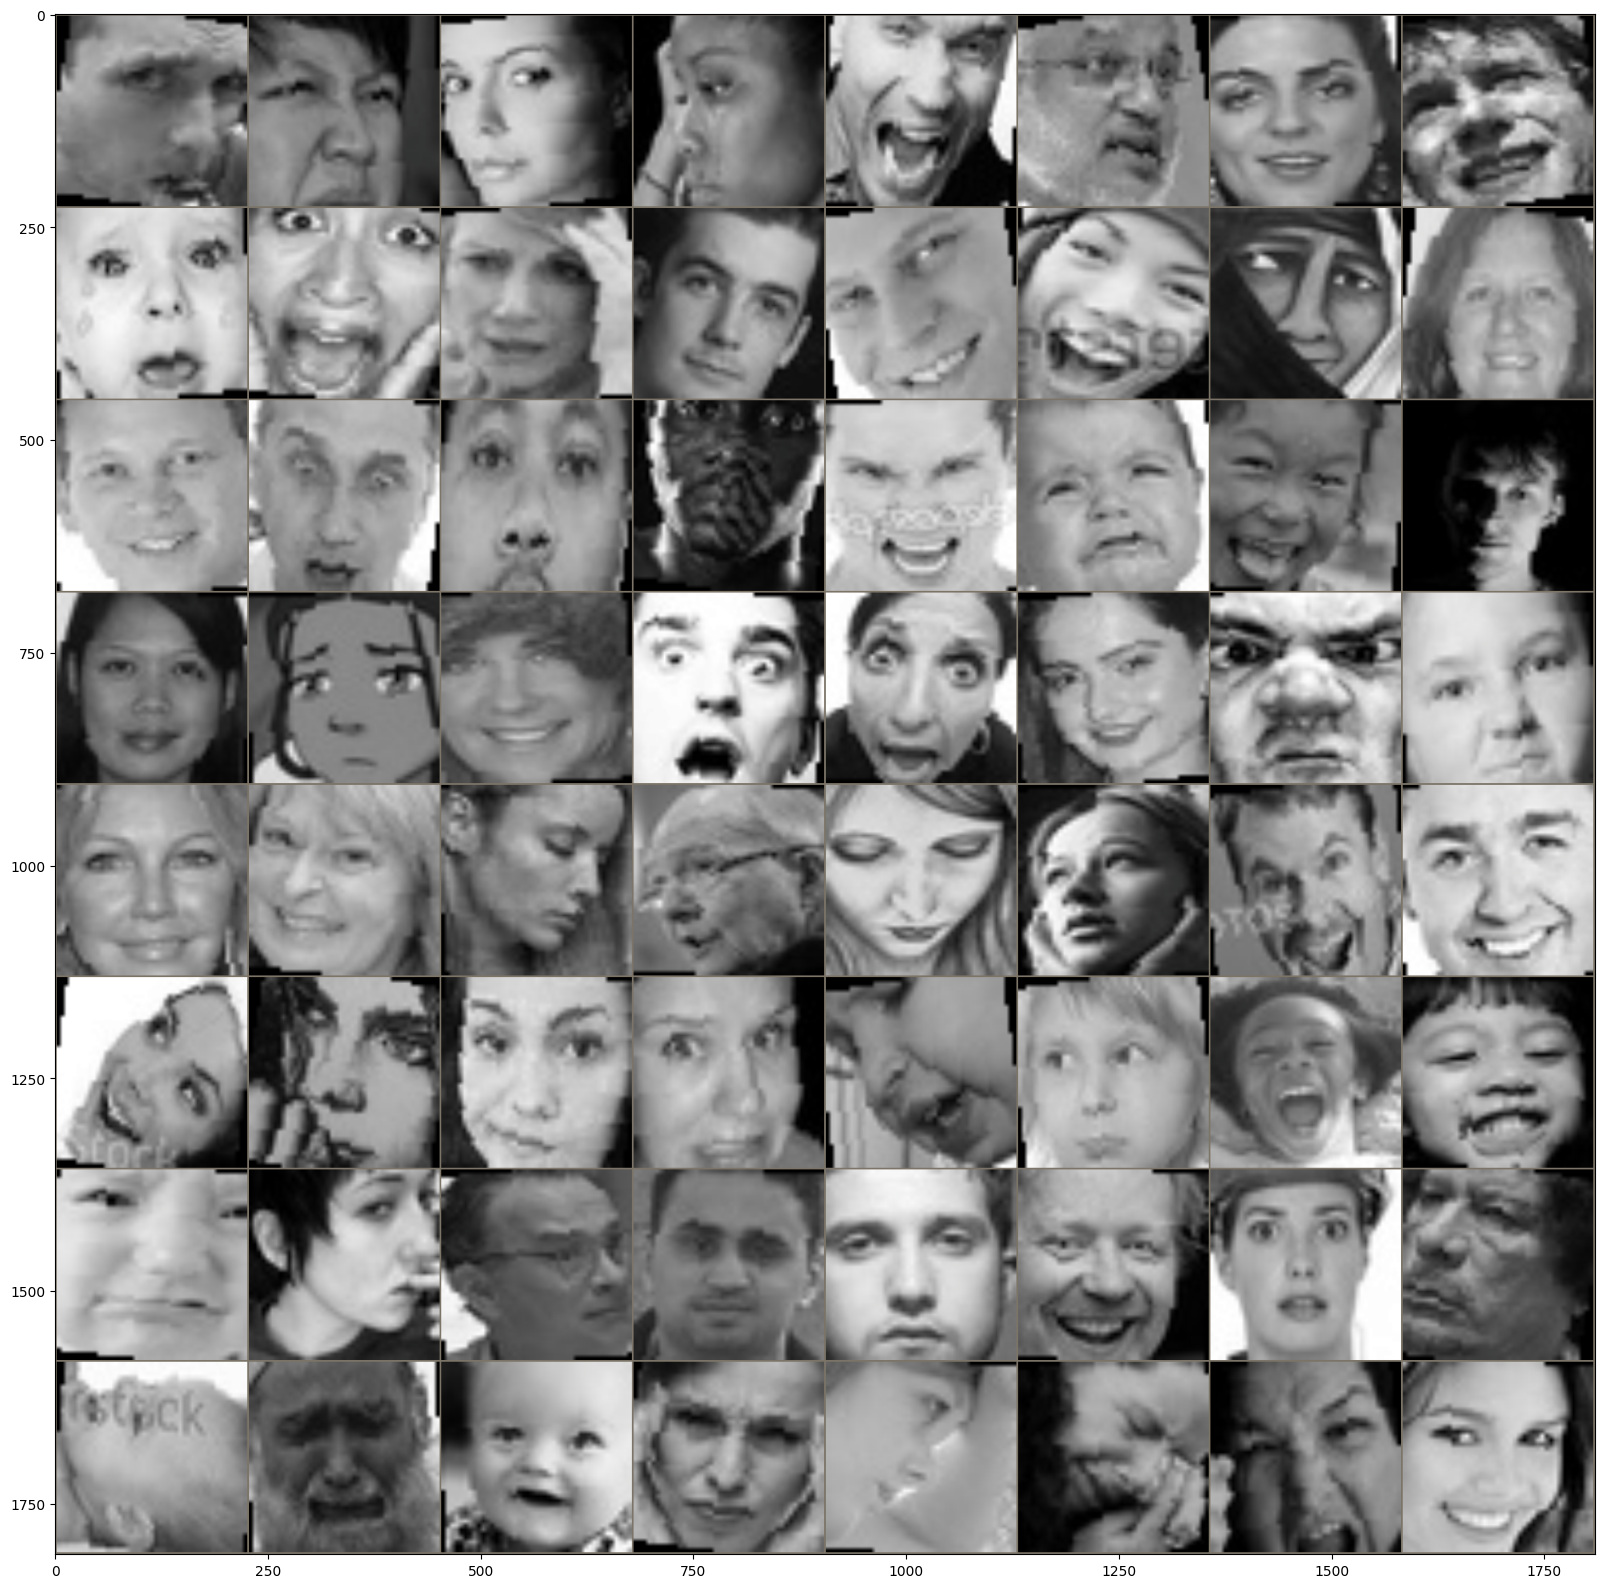

In [ ]:
def show_transformed_image(image):
  # Unormalize the channels.ImageNet weights.
  for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
    t.mul_(s).add_(m)

  np_image = image.numpy()

  plt.figure(figsize=(20, 20))
  plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualize `batch_size` images
dataloader_vis = torch.utils.data.DataLoader(dataset=train_set, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label = next(items)

show_transformed_image(utils.make_grid(image))

## Data Manipulation
---

torch.Size([3, 224, 224])
tensor(0)


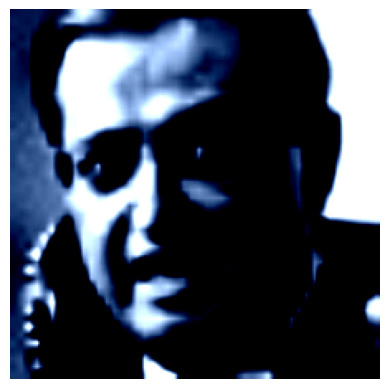

In [ ]:
# Class names:  ['angry', 'fear', 'happy', 'neutral', 'sad']

for data in train_loader:
  x, y = data[0][0], data[1][0]
  break

print(x.shape)
print(y.data)

x = x.permute(1, 2, 0)
image_np = x.squeeze(0).numpy()

plt.imshow(image_np, cmap='gray')
plt.axis('off')
plt.show()

## Define the CNN Architecture
---

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = models.mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Linear(1280, output_size)

  def forward(self, x):
    return self.mnet(x)

  def freeze(self):
    # Freeze all
    for param in self.mnet.parameters():
      param.requires_grad = False

    # Unfreeze the last block
    for param in self.mnet.features[-3:].parameters():
        param.requires_grad = True

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [ ]:
# config = set_config({
#     'batch_size': batch_size,
#     'crop_size': 224,
#     'output_size': num_classes
# })

In [ ]:
class Net(nn.Module):
    """
    Considering each image having 224 x 224 x 3:

    Input [3, 224, 224]
    Conv1(3, 6, 5) [6, 220, 220]
    Pool(2, 2) 16, 110, 110]
    Conv2(6, 16, 5) [16, 106, 106]
    Pool(2, 2) [16, 53, 53]
    Flatten [44944] (16 x 53 x 53 = 44944)
    Fc1 [120]
    Fc2 [84]
    Fc3 [5]
    """
    def __init__(self, in_channels, num_classes):
        """
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
                        dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # conv1(x): Input: [224, 224, 3]. Output: [220, 220, 6].
        x = self.conv1(x)
        x = F.relu(x)
        # pool: Input: [220, 220, 6], Output: [110, 110, 6]
        x = self.pool(x)
        # conv2: Input: [110, 110, 6]. Output: [106, 106, 16].
        x = self.conv2(x)
        x = F.relu(x)
        # pool: Input: [106, 106, 16], Output: [53, 53, 16]
        x = self.pool(x)
        # flatten: Input: [53, 53, 16]. Output: [44944]
        x = torch.flatten(x, 1)
        # fc1: Input: [44944]. Output: [120]
        x = self.fc1(x)
        x = F.relu(x)
        # fc2: Input: [120]. Output: [84]
        x = self.fc2(x)
        x = F.relu(x)
        # fc3: Input: [80]. Output: [num_classes]
        x = self.fc3(x)

        return F.softmax(x, dim=1)

## Using a pretrained model (fine-tunning)
---

## Selecting the model
- https://pytorch.org/vision/stable/models.html
----

In [ ]:
if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(3, num_classes)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Changes the number of neurons in the output layer.
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(pretrained=True).to(DEVICE)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes).to(DEVICE)

elif ARCH_NAME == 'mobilenetv2':
    model = CustomMobileNetv2(num_classes).to(DEVICE)

elif ARCH_NAME == 'inceptionv3':
    pass

# Include more architectures...
# ---
### elif ARCH_NAME == ...

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Calculate and print the total number of trainable parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_trainable_params}")
print(str(model))


Total trainable parameters: 11179077
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

## Loss function and optimizer
---

In [ ]:
# Loss function
# https://pytorch.org/docs/stable/nn.html
criterion = nn.CrossEntropyLoss()

# Optimizer
# https://pytorch.org/docs/stable/optim.html
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

# Callback
# callback = Callback(model, config, early_stop_patience=2, outdir='output')

# Learning rate scheduler
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=ss)

In [ ]:
# Pré-aquecimento da GPU (só se tiver CUDA disponível)
if DEVICE.type == "cuda":
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224, device=DEVICE)
        _ = model(dummy)

## Training the model
---

In [ ]:
# train_cost_list = []
# train_acc_list = []

def loop_fn(mode, epoch, dataset, dataloader, model, criterion, optimizer, device):

  if mode == 'train':
    model.train()

  elif mode == 'val':
    model.eval()

  cost = 0
  correct = 0

  for inputs, labels in tqdm(dataloader, desc=mode.title()):

    inputs, labels = inputs.to(device), labels.to(device)

    output = model(inputs)

    loss = criterion(output, labels)

    if mode == 'train':

      loss.backward()

      optimizer.step()

      optimizer.zero_grad()

    cost += loss.item() * inputs.shape[0]

    correct += (output.argmax(1) == labels).sum().item()

    cost = cost/len(dataset)
    acc = correct/len(dataset)

    # train_cost_list.append(cost)
    # train_acc_list.append(acc)

  # PRINTING
  # --------
  print(f"Epoch {epoch}/{ epochs - 1} \
    - {mode.title()} loss: {cost:.4f} \
    - {mode.title()} accuracy: {acc:.4f}")

  return cost, acc

In [ ]:
train_cost_list = []
train_acc_list = []

val_cost_list = []
val_acc_list = []

for epoch in range(epochs):
  train_cost, train_score = loop_fn('train', epoch, train_set, train_loader, model, criterion, optimizer, DEVICE)

  with torch.no_grad():
    val_cost, val_score = loop_fn('val', epoch, val_set, val_loader, model, criterion, optimizer, DEVICE)

  train_cost_list.append(train_cost)
  train_acc_list.append(train_score)

  val_cost_list.append(val_cost)
  val_acc_list.append(val_score)

# # Logging
# callback.log(train_cost, val_cost, train_score, val_score)

# # Checkpoint
# callback.save_checkpoint()

# # Runtime Plotting
# callback.cost_runtime_plotting()
# callback.score_runtime_plotting()

# # Early Stopping
# if callback.early_stopping(model, monitor='test_score'):
#   callback.plot_cost()
#   callback.plot_score()


Train: 100%|██████████| 390/390 [17:15<00:00,  2.66s/it]


Epoch 0/49     - Train loss: 0.0022     - Train accuracy: 0.5276


Val: 100%|██████████| 37/37 [07:34<00:00, 12.30s/it]


Epoch 0/49     - Val loss: 0.0230     - Val accuracy: 0.6004


Train: 100%|██████████| 390/390 [01:58<00:00,  3.28it/s]


Epoch 1/49     - Train loss: 0.0023     - Train accuracy: 0.6017


Val: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


Epoch 1/49     - Val loss: 0.0195     - Val accuracy: 0.5813


Train: 100%|██████████| 390/390 [02:00<00:00,  3.24it/s]


Epoch 2/49     - Train loss: 0.0018     - Train accuracy: 0.6225


Val: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


Epoch 2/49     - Val loss: 0.0173     - Val accuracy: 0.6136


Train: 100%|██████████| 390/390 [01:59<00:00,  3.25it/s]


Epoch 3/49     - Train loss: 0.0015     - Train accuracy: 0.6395


Val: 100%|██████████| 37/37 [00:08<00:00,  4.31it/s]


Epoch 3/49     - Val loss: 0.0189     - Val accuracy: 0.6430


Train: 100%|██████████| 390/390 [02:01<00:00,  3.21it/s]


Epoch 4/49     - Train loss: 0.0022     - Train accuracy: 0.6531


Val: 100%|██████████| 37/37 [00:10<00:00,  3.66it/s]


Epoch 4/49     - Val loss: 0.0225     - Val accuracy: 0.6315


Train: 100%|██████████| 390/390 [02:02<00:00,  3.20it/s]


Epoch 5/49     - Train loss: 0.0017     - Train accuracy: 0.6619


Val: 100%|██████████| 37/37 [00:08<00:00,  4.49it/s]


Epoch 5/49     - Val loss: 0.0192     - Val accuracy: 0.6277


Train: 100%|██████████| 390/390 [01:59<00:00,  3.26it/s]


Epoch 6/49     - Train loss: 0.0015     - Train accuracy: 0.6724


Val: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]


Epoch 6/49     - Val loss: 0.0154     - Val accuracy: 0.6353


Train: 100%|██████████| 390/390 [01:59<00:00,  3.25it/s]


Epoch 7/49     - Train loss: 0.0019     - Train accuracy: 0.6880


Val: 100%|██████████| 37/37 [00:09<00:00,  4.11it/s]


Epoch 7/49     - Val loss: 0.0160     - Val accuracy: 0.6630


Train: 100%|██████████| 390/390 [01:57<00:00,  3.33it/s]


Epoch 8/49     - Train loss: 0.0020     - Train accuracy: 0.6935


Val: 100%|██████████| 37/37 [00:08<00:00,  4.50it/s]


Epoch 8/49     - Val loss: 0.0141     - Val accuracy: 0.6609


Train: 100%|██████████| 390/390 [01:59<00:00,  3.25it/s]


Epoch 9/49     - Train loss: 0.0012     - Train accuracy: 0.7012


Val: 100%|██████████| 37/37 [00:09<00:00,  3.81it/s]


Epoch 9/49     - Val loss: 0.0144     - Val accuracy: 0.6502


Train: 100%|██████████| 390/390 [02:01<00:00,  3.21it/s]


Epoch 10/49     - Train loss: 0.0013     - Train accuracy: 0.7136


Val: 100%|██████████| 37/37 [00:09<00:00,  4.06it/s]


Epoch 10/49     - Val loss: 0.0185     - Val accuracy: 0.6528


Train: 100%|██████████| 390/390 [01:58<00:00,  3.28it/s]


Epoch 11/49     - Train loss: 0.0013     - Train accuracy: 0.7249


Val: 100%|██████████| 37/37 [00:09<00:00,  3.89it/s]


Epoch 11/49     - Val loss: 0.0188     - Val accuracy: 0.6621


Train: 100%|██████████| 390/390 [01:57<00:00,  3.31it/s]


Epoch 12/49     - Train loss: 0.0012     - Train accuracy: 0.7306


Val: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


Epoch 12/49     - Val loss: 0.0156     - Val accuracy: 0.6783


Train: 100%|██████████| 390/390 [01:58<00:00,  3.29it/s]


Epoch 13/49     - Train loss: 0.0015     - Train accuracy: 0.7407


Val: 100%|██████████| 37/37 [00:09<00:00,  3.94it/s]


Epoch 13/49     - Val loss: 0.0144     - Val accuracy: 0.6702


Train: 100%|██████████| 390/390 [01:59<00:00,  3.27it/s]


Epoch 14/49     - Train loss: 0.0024     - Train accuracy: 0.7491


Val: 100%|██████████| 37/37 [00:08<00:00,  4.18it/s]


Epoch 14/49     - Val loss: 0.0125     - Val accuracy: 0.6740


Train: 100%|██████████| 390/390 [02:00<00:00,  3.24it/s]


Epoch 15/49     - Train loss: 0.0013     - Train accuracy: 0.7579


Val: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Epoch 15/49     - Val loss: 0.0206     - Val accuracy: 0.6821


Train: 100%|██████████| 390/390 [02:02<00:00,  3.17it/s]


Epoch 16/49     - Train loss: 0.0013     - Train accuracy: 0.7680


Val: 100%|██████████| 37/37 [00:08<00:00,  4.45it/s]


Epoch 16/49     - Val loss: 0.0244     - Val accuracy: 0.6732


Train: 100%|██████████| 390/390 [02:00<00:00,  3.24it/s]


Epoch 17/49     - Train loss: 0.0010     - Train accuracy: 0.7770


Val: 100%|██████████| 37/37 [00:09<00:00,  3.91it/s]


Epoch 17/49     - Val loss: 0.0211     - Val accuracy: 0.6813


Train: 100%|██████████| 390/390 [02:02<00:00,  3.18it/s]


Epoch 18/49     - Train loss: 0.0012     - Train accuracy: 0.7872


Val: 100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch 18/49     - Val loss: 0.0136     - Val accuracy: 0.6681


Train: 100%|██████████| 390/390 [02:00<00:00,  3.23it/s]


Epoch 19/49     - Train loss: 0.0014     - Train accuracy: 0.7938


Val: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]


Epoch 19/49     - Val loss: 0.0150     - Val accuracy: 0.6791


Train: 100%|██████████| 390/390 [01:59<00:00,  3.25it/s]


Epoch 20/49     - Train loss: 0.0009     - Train accuracy: 0.8049


Val: 100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


Epoch 20/49     - Val loss: 0.0183     - Val accuracy: 0.6723


Train: 100%|██████████| 390/390 [02:00<00:00,  3.24it/s]


Epoch 21/49     - Train loss: 0.0009     - Train accuracy: 0.8148


Val: 100%|██████████| 37/37 [00:09<00:00,  4.07it/s]


Epoch 21/49     - Val loss: 0.0229     - Val accuracy: 0.6621


Train: 100%|██████████| 390/390 [01:59<00:00,  3.26it/s]


Epoch 22/49     - Train loss: 0.0011     - Train accuracy: 0.8273


Val: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]


Epoch 22/49     - Val loss: 0.0129     - Val accuracy: 0.6830


Train: 100%|██████████| 390/390 [02:03<00:00,  3.17it/s]


Epoch 23/49     - Train loss: 0.0007     - Train accuracy: 0.8306


Val: 100%|██████████| 37/37 [00:08<00:00,  4.26it/s]


Epoch 23/49     - Val loss: 0.0218     - Val accuracy: 0.6528


Train: 100%|██████████| 390/390 [02:03<00:00,  3.15it/s]


Epoch 24/49     - Train loss: 0.0005     - Train accuracy: 0.8413


Val: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]


Epoch 24/49     - Val loss: 0.0174     - Val accuracy: 0.6532


Train: 100%|██████████| 390/390 [02:02<00:00,  3.19it/s]


Epoch 25/49     - Train loss: 0.0006     - Train accuracy: 0.8464


Val: 100%|██████████| 37/37 [00:08<00:00,  4.30it/s]


Epoch 25/49     - Val loss: 0.0189     - Val accuracy: 0.6762


Train: 100%|██████████| 390/390 [02:02<00:00,  3.19it/s]


Epoch 26/49     - Train loss: 0.0007     - Train accuracy: 0.8555


Val: 100%|██████████| 37/37 [00:09<00:00,  3.84it/s]


Epoch 26/49     - Val loss: 0.0179     - Val accuracy: 0.6664


Train: 100%|██████████| 390/390 [02:03<00:00,  3.15it/s]


Epoch 27/49     - Train loss: 0.0005     - Train accuracy: 0.8611


Val: 100%|██████████| 37/37 [00:08<00:00,  4.22it/s]


Epoch 27/49     - Val loss: 0.0183     - Val accuracy: 0.6936


Train: 100%|██████████| 390/390 [02:02<00:00,  3.18it/s]


Epoch 28/49     - Train loss: 0.0010     - Train accuracy: 0.8673


Val: 100%|██████████| 37/37 [00:09<00:00,  3.73it/s]


Epoch 28/49     - Val loss: 0.0380     - Val accuracy: 0.6740


Train: 100%|██████████| 390/390 [02:04<00:00,  3.13it/s]


Epoch 29/49     - Train loss: 0.0011     - Train accuracy: 0.8751


Val: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]


Epoch 29/49     - Val loss: 0.0208     - Val accuracy: 0.6672


Train: 100%|██████████| 390/390 [02:01<00:00,  3.20it/s]


Epoch 30/49     - Train loss: 0.0007     - Train accuracy: 0.8799


Val: 100%|██████████| 37/37 [00:09<00:00,  3.77it/s]


Epoch 30/49     - Val loss: 0.0222     - Val accuracy: 0.6813


Train: 100%|██████████| 390/390 [02:05<00:00,  3.10it/s]


Epoch 31/49     - Train loss: 0.0007     - Train accuracy: 0.8826


Val: 100%|██████████| 37/37 [00:10<00:00,  3.70it/s]


Epoch 31/49     - Val loss: 0.0186     - Val accuracy: 0.6864


Train: 100%|██████████| 390/390 [02:05<00:00,  3.12it/s]


Epoch 32/49     - Train loss: 0.0008     - Train accuracy: 0.8906


Val: 100%|██████████| 37/37 [00:09<00:00,  3.74it/s]


Epoch 32/49     - Val loss: 0.0148     - Val accuracy: 0.6885


Train: 100%|██████████| 390/390 [02:04<00:00,  3.13it/s]


Epoch 33/49     - Train loss: 0.0004     - Train accuracy: 0.8945


Val: 100%|██████████| 37/37 [00:09<00:00,  4.08it/s]


Epoch 33/49     - Val loss: 0.0252     - Val accuracy: 0.6894


Train: 100%|██████████| 390/390 [02:07<00:00,  3.05it/s]


Epoch 34/49     - Train loss: 0.0006     - Train accuracy: 0.8987


Val: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Epoch 34/49     - Val loss: 0.0273     - Val accuracy: 0.6766


Train: 100%|██████████| 390/390 [02:05<00:00,  3.12it/s]


Epoch 35/49     - Train loss: 0.0011     - Train accuracy: 0.9042


Val: 100%|██████████| 37/37 [00:09<00:00,  3.78it/s]


Epoch 35/49     - Val loss: 0.0245     - Val accuracy: 0.6872


Train: 100%|██████████| 390/390 [02:00<00:00,  3.25it/s]


Epoch 36/49     - Train loss: 0.0005     - Train accuracy: 0.9074


Val: 100%|██████████| 37/37 [00:09<00:00,  3.76it/s]


Epoch 36/49     - Val loss: 0.0274     - Val accuracy: 0.6936


Train: 100%|██████████| 390/390 [02:02<00:00,  3.19it/s]


Epoch 37/49     - Train loss: 0.0005     - Train accuracy: 0.9093


Val: 100%|██████████| 37/37 [00:09<00:00,  3.95it/s]


Epoch 37/49     - Val loss: 0.0213     - Val accuracy: 0.6766


Train: 100%|██████████| 390/390 [01:59<00:00,  3.25it/s]


Epoch 38/49     - Train loss: 0.0004     - Train accuracy: 0.9156


Val: 100%|██████████| 37/37 [00:09<00:00,  3.85it/s]


Epoch 38/49     - Val loss: 0.0332     - Val accuracy: 0.6838


Train: 100%|██████████| 390/390 [02:03<00:00,  3.15it/s]


Epoch 39/49     - Train loss: 0.0003     - Train accuracy: 0.9165


Val: 100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch 39/49     - Val loss: 0.0285     - Val accuracy: 0.6779


Train: 100%|██████████| 390/390 [02:00<00:00,  3.24it/s]


Epoch 40/49     - Train loss: 0.0007     - Train accuracy: 0.9220


Val: 100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


Epoch 40/49     - Val loss: 0.0161     - Val accuracy: 0.6766


Train: 100%|██████████| 390/390 [02:01<00:00,  3.21it/s]


Epoch 41/49     - Train loss: 0.0003     - Train accuracy: 0.9211


Val: 100%|██████████| 37/37 [00:09<00:00,  4.10it/s]


Epoch 41/49     - Val loss: 0.0133     - Val accuracy: 0.6860


Train: 100%|██████████| 390/390 [02:08<00:00,  3.04it/s]


Epoch 42/49     - Train loss: 0.0004     - Train accuracy: 0.9252


Val: 100%|██████████| 37/37 [00:09<00:00,  3.74it/s]


Epoch 42/49     - Val loss: 0.0265     - Val accuracy: 0.6719


Train: 100%|██████████| 390/390 [02:03<00:00,  3.17it/s]


Epoch 43/49     - Train loss: 0.0004     - Train accuracy: 0.9267


Val: 100%|██████████| 37/37 [00:09<00:00,  3.87it/s]


Epoch 43/49     - Val loss: 0.0303     - Val accuracy: 0.6834


Train: 100%|██████████| 390/390 [01:58<00:00,  3.28it/s]


Epoch 44/49     - Train loss: 0.0004     - Train accuracy: 0.9281


Val: 100%|██████████| 37/37 [00:09<00:00,  3.73it/s]


Epoch 44/49     - Val loss: 0.0216     - Val accuracy: 0.6800


Train: 100%|██████████| 390/390 [02:01<00:00,  3.21it/s]


Epoch 45/49     - Train loss: 0.0004     - Train accuracy: 0.9279


Val: 100%|██████████| 37/37 [00:08<00:00,  4.46it/s]


Epoch 45/49     - Val loss: 0.0258     - Val accuracy: 0.6838


Train: 100%|██████████| 390/390 [02:05<00:00,  3.12it/s]


Epoch 46/49     - Train loss: 0.0003     - Train accuracy: 0.9343


Val: 100%|██████████| 37/37 [00:09<00:00,  3.79it/s]


Epoch 46/49     - Val loss: 0.0517     - Val accuracy: 0.6804


Train: 100%|██████████| 390/390 [02:00<00:00,  3.23it/s]


Epoch 47/49     - Train loss: 0.0006     - Train accuracy: 0.9375


Val: 100%|██████████| 37/37 [00:09<00:00,  4.08it/s]


Epoch 47/49     - Val loss: 0.0214     - Val accuracy: 0.6779


Train: 100%|██████████| 390/390 [02:00<00:00,  3.23it/s]


Epoch 48/49     - Train loss: 0.0004     - Train accuracy: 0.9376


Val: 100%|██████████| 37/37 [00:09<00:00,  3.83it/s]


Epoch 48/49     - Val loss: 0.0242     - Val accuracy: 0.6809


Train: 100%|██████████| 390/390 [02:03<00:00,  3.16it/s]


Epoch 49/49     - Train loss: 0.0002     - Train accuracy: 0.9411


Val: 100%|██████████| 37/37 [00:08<00:00,  4.47it/s]


Epoch 49/49     - Val loss: 0.0293     - Val accuracy: 0.6804


## Saving and Load the trained model
---

In [ ]:
torch.save(model.state_dict(), os.path.join(EXP_PATH, f"fer-classification-{ARCH_NAME}-model.pth"))

In [ ]:
# List with epoch indexes. [0, 1, ... num_epochs - 1]
epochs_list = list(range(len(train_cost_list)))

## Evaluation Metrics
---

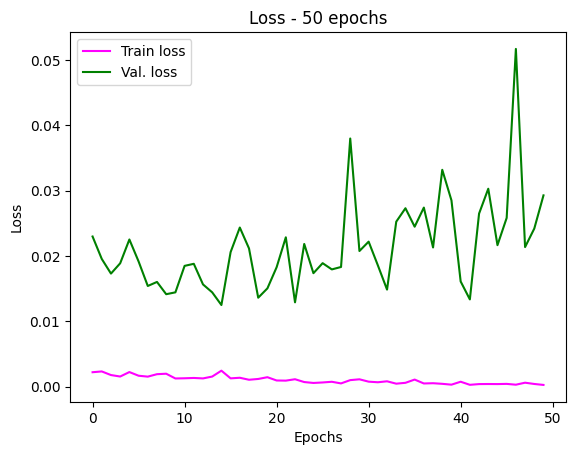

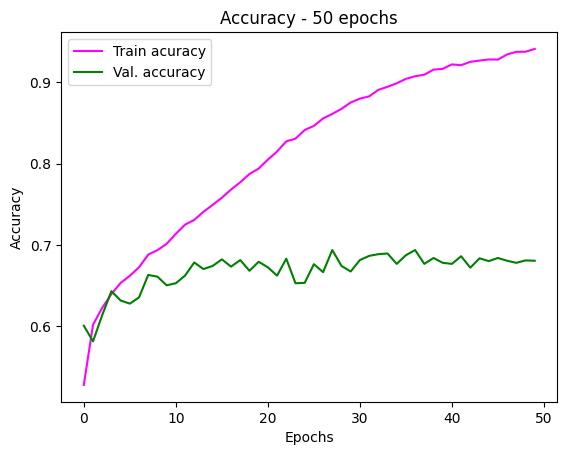

In [ ]:
# List with epoch indexes. [0, 1, ... num_epochs - 1]
epochs_list = list(range(len(train_cost_list)))

# Plot - Loss
plt.figure()
plt.title(f'Loss - {epochs} epochs')
plt.plot(epochs_list, train_cost_list, c='magenta', ls='-', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_cost_list, c='green', ls='-', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Plot - Accuracy
plt.figure()
plt.title(f'Accuracy - {epochs} epochs')
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

## Evaluating the model over the test set
---

In [ ]:
# List with true and predicted classes
true_val_list = []
pred_val_list = []
# List with probabilities
prob_val_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, label_list) in enumerate(test_loader):
    # Send data to GPU
    img_list = img_list.to(DEVICE)
    labelList = label_list.to(DEVICE)

    # Disables gradient calculation during validation and testing.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Model output
    outputs = model(img_list)

    # Prediction
    preds = torch.argmax(outputs, dim=1)

    # Computes probabilities of each class
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)

    # True classes and predicted classes for this batch.
    if DEVICE.type == 'cuda':
        true_val_batch = list(label_list.cpu())
        pred_val_batch = list(preds.cpu())
        prob_val_batch = list(outputs_prob.cpu())
    else:
        true_val_batch = list(label_list)
        pred_val_batch = list(preds)
        prob_val_batch = list(outputs_prob)

    # Append batch results to the lists
    true_val_list += true_val_batch
    pred_val_list += pred_val_batch

    prob_val_list += prob_val_batch

## Confusion matrix and classification report
---

In [ ]:
# Confusion matrix
conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
print('\nConfusion matrix (validation)')
print(conf_mat_val)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(true_val_list, pred_val_list,
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))